## Steam data cleaning for linear regression:

### Cleaning the scraped data and combining it with SteamDB data:

In [169]:
import pandas as pd
import seaborn as sns
import patsy
import statsmodels.api as sm

import numpy as np

import pickle

from sklearn.feature_extraction.text import CountVectorizer as cv

### Load my scraped Steam data:

In [43]:
steam_games_df = pd.read_json('steam_games_dicts_selenium.json')

### Inspect the data:

In [44]:
steam_games_df.shape

(23410, 22)

In [45]:
steam_games_df.head()

Developer                               Genre  \
0         [WTFOMGames]  [Action, Adventure, Casual, Indie]   
1         [VRUnicorns]                     [Indie, Sports]   
2  [Red Dolphin Games]                  [Casual, Strategy]   
3        [Beatshapers]                     [Action, Indie]   
4       [Paleno Games]                     [Casual, Indie]   

               Publisher  Release Date  \
0           [WTFOMGames]   Mar 1, 2016   
1             [Bandello]  Dec 19, 2017   
2        [VT Publishing]  Apr 24, 2018   
3  [8Floor, Beatshapers]  Aug 10, 2016   
4         [Paleno Games]   May 5, 2017   

                                          Title  app_id  \
0  ! That Bastard Is Trying To Steal Our Gold !  449940   
1                                      #Archery  493790   
2                               #Have A Sticker  841860   
3                               #KILLALLZOMBIES  303720   
4                                 #monstercakes  614910   

                                       app_name discount_price  early_access  \
0  ! That Bastard Is Trying To Steal Our Gold !           3.99         False   
1                                      #Archery           4.99         False   
2                               #Have A Sticker          14.99         False   
3                               #KILLALLZOMBIES           4.99         False   
4                                 #monstercakes           0.99         False   

  esrb                        ...                          \
0                             ...                           
1                             ...                           
2                             ...                           
3    t                        ...                           
4                             ...                           

  overall_rev_pos_perc overall_reviews_n  price  recent_rev_pos_perc  \
0                   46                15   3.99                    0   
1                   64                17   9.99                    0   
2                    0                 0  19.99                    0   
3                   47                19   4.99                    0   
4                   90               272   0.99                   80   

   recent_reviews_n                                        reviews_url  \
0                 0  http://steamcommunity.com/app/449940/reviews/?...   
1                 0  http://steamcommunity.com/app/493790/reviews/?...   
2                 0  http://steamcommunity.com/app/841860/reviews/?...   
3                 0  http://steamcommunity.com/app/303720/reviews/?...   
4                10  http://steamcommunity.com/app/614910/reviews/?...   

                                               specs steam_Achievement_n  \
0  [Single-player, Steam Trading Cards, Partial C...                   0   
1  [Single-player, Local Multi-Player, Steam Achi...                   9   
2                                    [Single-player]                   0   
3  [Single-player, Local Co-op, Shared/Split Scre...                  10   
4  [Single-player, Steam Achievements, Steam Trad...                  18   

                                                tags  \
0  [Action, Indie, Casual, Adventure, Memes, Psyc...   
1                                [Indie, Sports, VR]   
2                                 [Strategy, Casual]   
3       [Action, Indie, Zombies, Twin Stick Shooter]   
4                   [Casual, Indie, Puzzle, Match 3]   

                                                 url  
0  https://store.steampowered.com/app/449940/_Tha...  
1  https://store.steampowered.com/app/493790/Arch...  
2  https://store.steampowered.com/app/841860/Have...  
3  https://store.steampowered.com/app/303720/KILL...  
4  https://store.steampowered.com/app/614910/mons...  

[5 rows x 22 columns]

In [46]:
steam_games_df.describe()

overall_rev_pos_perc  overall_reviews_n         price  \
count          23410.000000       2.341000e+04  22969.000000   
mean              42.589492       9.056343e+02     10.454253   
std               38.234172       1.561972e+04     13.311077   
min                0.000000       0.000000e+00      0.000000   
25%                0.000000       0.000000e+00      2.990000   
50%               51.000000       1.800000e+01      6.990000   
75%               80.000000       1.150000e+02     12.990000   
max               99.000000       1.836783e+06    689.750000   

       recent_rev_pos_perc  steam_Achievement_n  
count         23410.000000         23410.000000  
mean              8.013199            12.723366  
std              23.823723            18.712390  
min               0.000000             0.000000  
25%               0.000000             0.000000  
50%               0.000000             0.000000  
75%               0.000000            20.000000  
max              99.000000            99.000000

In [47]:
steam_games_df.fillna(value=0, inplace=True) 

In [48]:
steam_games_df.price.dtype

dtype('float64')

In [49]:
steam_games_df.overall_reviews_n.dtype

dtype('int64')

In [50]:
steam_games_df.columns

Index(['Developer', 'Genre', 'Publisher', 'Release Date', 'Title', 'app_id',
       'app_name', 'discount_price', 'early_access', 'esrb', 'mature_reasons',
       'metascore', 'overall_rev_pos_perc', 'overall_reviews_n', 'price',
       'recent_rev_pos_perc', 'recent_reviews_n', 'reviews_url', 'specs',
       'steam_Achievement_n', 'tags', 'url'],
      dtype='object')

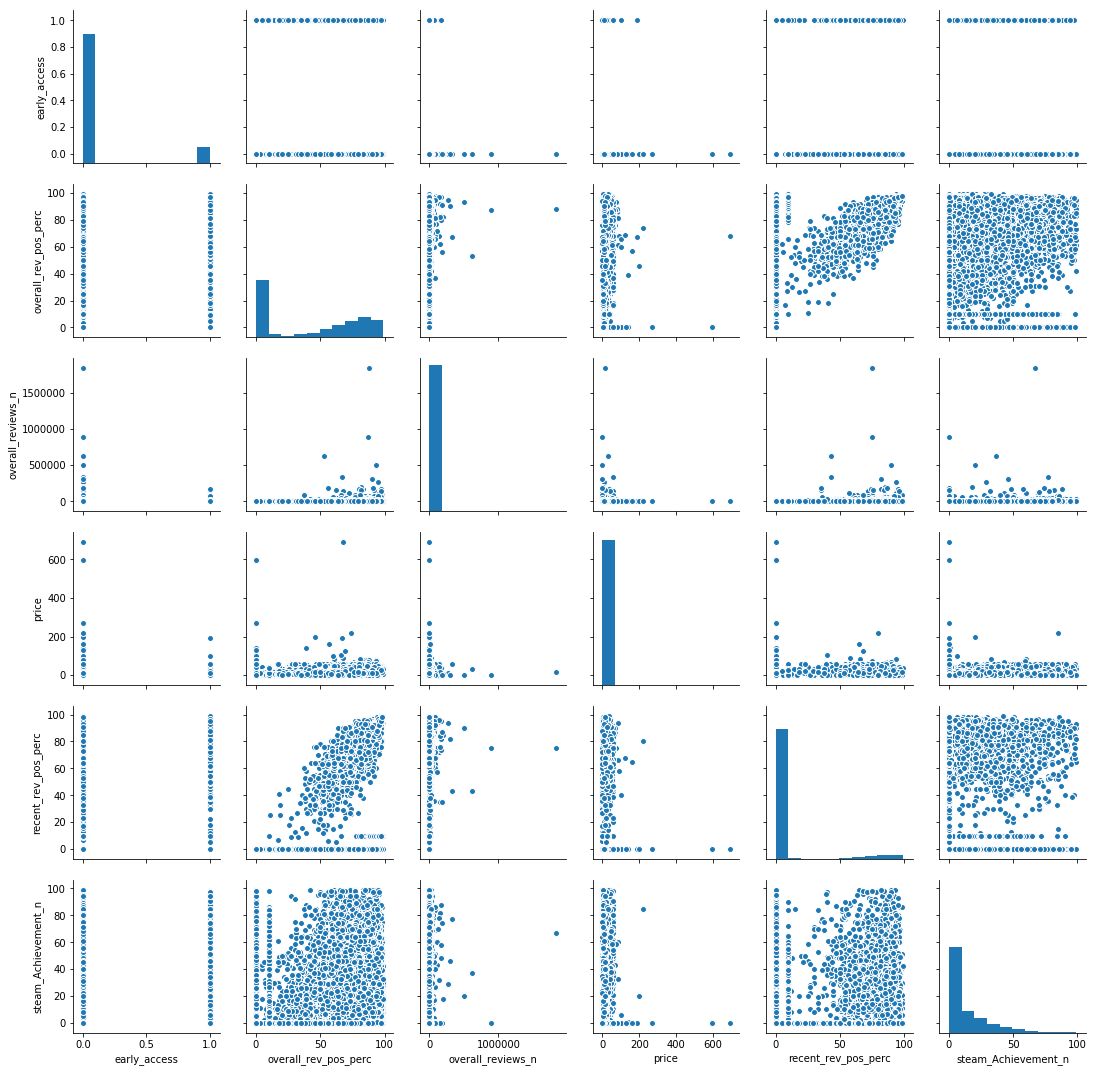

In [51]:
sns.pairplot(steam_games_df);

### Load my scraped SteamDB concurrent number of users data:

In [52]:
steamDB_users_df = pd.read_csv('steam_users_table.csv', thousands=',')

### Unfortunately, we can see that by predicting a value in the steamDB dataframe, we'll be losing quite a few games.

In [53]:
print("Number of games I got data for from Steam:",len(steam_games_df))
print("Number of games in steamDB with concurrent user information:",len(steamDB_users_df))

Number of games I got data for from Steam: 23410
Number of games in steamDB with concurrent user information: 8503


### Inspect the concurrent users data:

In [54]:
steamDB_users_df.shape

(8503, 5)

In [55]:
steamDB_users_df.head()

AppID                              Name  Current  24h Peak  \
0     753.0                             Steam  9469112  14752493   
1  578080.0     PLAYERUNKNOWN'S BATTLEGROUNDS   282809   1992584   
2     570.0                            Dota 2   226441    621653   
3     730.0  Counter-Strike: Global Offensive   172999    421633   
4  359550.0    Tom Clancy's Rainbow Six Siege    40794     99486   

   All-Time Peak  
0       18537490  
1        3257248  
2        1295114  
3         854801  
4         178953

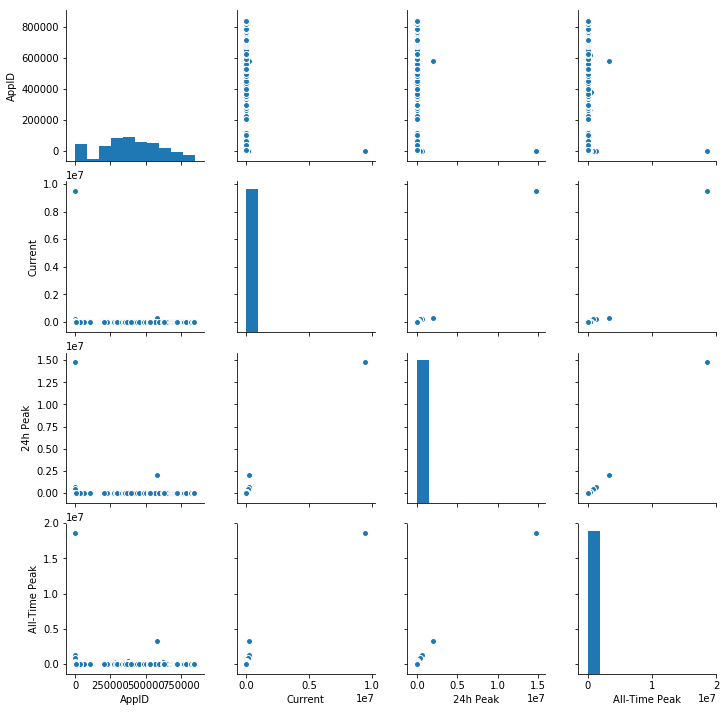

In [56]:
sns.pairplot(steamDB_users_df);

In [57]:
steamDB_users_df.columns

Index(['AppID', 'Name', 'Current', '24h Peak', 'All-Time Peak'], dtype='object')

In [58]:
steamDB_users_df['All-Time Peak'].dtype

dtype('int64')

In [59]:
steamDB_users_df['Name'] = steamDB_users_df['Name'].astype('str')

In [60]:
steamDB_users_df['Name'].dtype

dtype('O')

In [61]:
type(steamDB_users_df.Name[0])

str

In [62]:
steamDB_users_df['AppID'] = steamDB_users_df['AppID'].astype('int64')

In [63]:
steamDB_users_df['AppID'].dtype

dtype('int64')

### Combining the two tables:

In [93]:
steam_combined = pd.merge(steam_games_df, steamDB_users_df, left_on='app_name', right_on='Name', how='inner', sort=False)
steam_combined.shape

(6478, 27)

### We didn't recover all of the games during the merge:

In [94]:
missing_names = set(steamDB_users_df['Name']).difference(set(steam_games_df['app_name']))
print("Number of missing games after merging tables:",len(missing_names),"of",len(steamDB_users_df))

Number of missing games after merging tables: 2040 of 8503


### Maybe we can clean up some of the special characters and improve the match:

In [95]:
# Combining all cleaning of steam_games_df:

# removing two symbols present in one frame that appear absent from the other
steam_games_df['app_name'].replace(regex=True,inplace=True,to_replace=r'®',value=r'')
steam_games_df['app_name'].replace(regex=True,inplace=True,to_replace=r'™',value=r'')

# removing these two symbols gives us 6478 instead of 6428 rows after merging

In [97]:
# combine the tables (again, but now without those symbols):
steam_combined = pd.merge(steam_games_df, steamDB_users_df, left_on='app_name', right_on='Name', how='inner', sort=False)

In [98]:
steam_combined.shape

(6478, 27)

### We improved it, but not by a lot:

In [99]:
print("Number of missing games after merging tables:",len(missing_names),"of",len(steamDB_users_df))

Number of missing games after merging tables: 2040 of 8503


### Fuzzy matching to recover additional games:

In [100]:
import fuzzywuzzy
from fuzzywuzzy import process

In [101]:
steamDB_users_df_fuzzy = steamDB_users_df.copy()

In [103]:
f = open("fuzzy_match_output.txt","w+")
f.close()
match_names=[]
scores=[]

for name in steamDB_users_df['Name']:
    if name in missing_names:
        match_name, score = process.extractOne(name, list(steam_games_df['app_name']))
    else:
        match_name = name
        score = 100
    match_names.append(match_name)
    scores.append(score)
#     print(name, '~', match_name, ' : ', score)
    print(name, '~', match_name, ' : ', score, file=open('fuzzy_match_output.txt', 'a'))

steamDB_users_df_fuzzy['steam_match_name'] = match_names
steamDB_users_df_fuzzy['fuzzy_score'] = scores

### Showing some example matches:
#### Inspecting many examples led me to pick a 93% match threshold. Below this score, we get some comically bad matches, but above this threshold, matches seem quite good.

In [104]:
fuzzy_example = pd.DataFrame()
fuzzy_example['SteamDB_Name'] = steamDB_users_df['Name']
fuzzy_example['Best_Steam_Name_Match'] = match_names
fuzzy_example['Fuzzy_Score'] = scores
fuzzy_example.head()

SteamDB_Name                     Best_Steam_Name_Match  \
0                             Steam  A Study in Steampunk: Choice by Gaslight   
1     PLAYERUNKNOWN'S BATTLEGROUNDS             PLAYERUNKNOWN'S BATTLEGROUNDS   
2                            Dota 2                                    Dota 2   
3  Counter-Strike: Global Offensive          Counter-Strike: Global Offensive   
4    Tom Clancy's Rainbow Six Siege            Tom Clancy's Rainbow Six Siege   

   Fuzzy_Score  
0           90  
1          100  
2          100  
3          100  
4          100

In [105]:
steamDB_users_df_fuzzy_final = steamDB_users_df_fuzzy.loc[steamDB_users_df_fuzzy.fuzzy_score >93].copy()
steamDB_users_df_fuzzy_final.head()

AppID                              Name  Current  24h Peak  All-Time Peak  \
1  578080     PLAYERUNKNOWN'S BATTLEGROUNDS   282809   1992584        3257248   
2     570                            Dota 2   226441    621653        1295114   
3     730  Counter-Strike: Global Offensive   172999    421633         854801   
4  359550    Tom Clancy's Rainbow Six Siege    40794     99486         178953   
5     440                   Team Fortress 2    38309     45415         120436   

                   steam_match_name  fuzzy_score  
1     PLAYERUNKNOWN'S BATTLEGROUNDS          100  
2                            Dota 2          100  
3  Counter-Strike: Global Offensive          100  
4    Tom Clancy's Rainbow Six Siege          100  
5                   Team Fortress 2          100

In [106]:
steamDB_users_df_fuzzy_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7277 entries, 1 to 8502
Data columns (total 7 columns):
AppID               7277 non-null int64
Name                7277 non-null object
Current             7277 non-null int64
24h Peak            7277 non-null int64
All-Time Peak       7277 non-null int64
steam_match_name    7277 non-null object
fuzzy_score         7277 non-null int64
dtypes: int64(5), object(2)
memory usage: 454.8+ KB


In [107]:
steam_combined_fuzzy = pd.merge(steam_games_df, steamDB_users_df_fuzzy_final, left_on='app_name', right_on='steam_match_name', how='inner', sort=False)

In [108]:
# check number of recovered entries
len(steamDB_users_df_fuzzy_final)-len(steam_combined)

799

In [109]:
steam_combined_fuzzy.head()

Developer                               Genre  \
0       [WTFOMGames]  [Action, Adventure, Casual, Indie]   
1      [Beatshapers]                     [Action, Indie]   
2     [Paleno Games]                     [Casual, Indie]   
3              [Eko]                  [Adventure, Indie]   
4  [BeHappy Studios]             [Action, Casual, Indie]   

                 Publisher  Release Date  \
0             [WTFOMGames]   Mar 1, 2016   
1    [8Floor, Beatshapers]  Aug 10, 2016   
2           [Paleno Games]   May 5, 2017   
3                    [Eko]  Mar 14, 2018   
4  [Back To Basics Gaming]  Jul 28, 2016   

                                          Title  app_id  \
0  ! That Bastard Is Trying To Steal Our Gold !  449940   
1                               #KILLALLZOMBIES  303720   
2                                 #monstercakes  614910   
3                                     #WarGames  779420   
4                                       $1 Ride  508290   

                                       app_name discount_price  early_access  \
0  ! That Bastard Is Trying To Steal Our Gold !           3.99         False   
1                               #KILLALLZOMBIES           4.99         False   
2                                 #monstercakes           0.99         False   
3                                     #WarGames           2.99         False   
4                                       $1 Ride           0.98         False   

  esrb     ...      steam_Achievement_n  \
0          ...                        0   
1    t     ...                       10   
2          ...                       18   
3          ...                       55   
4          ...                        0   

                                                tags  \
0  [Action, Indie, Casual, Adventure, Memes, Psyc...   
1       [Action, Indie, Zombies, Twin Stick Shooter]   
2                   [Casual, Indie, Puzzle, Match 3]   
3                            [Adventure, Indie, FMV]   
4                            [Casual, Indie, Action]   

                                                 url   AppID  \
0  https://store.steampowered.com/app/449940/_Tha...  449940   
1  https://store.steampowered.com/app/303720/KILL...  303720   
2  https://store.steampowered.com/app/614910/mons...  614910   
3  https://store.steampowered.com/app/779420/WarG...  779420   
4  https://store.steampowered.com/app/508290/1_Ride/  508290   

                                           Name  Current 24h Peak  \
0  ! That Bastard Is Trying To Steal Our Gold !        1       27   
1                               #killallzombies        2      163   
2                                 #monstercakes       57       70   
3                                     #WarGames        2        5   
4                                       $1 Ride        1        4   

  All-Time Peak                              steam_match_name  fuzzy_score  
0          1951  ! That Bastard Is Trying To Steal Our Gold !          100  
1          3879                               #KILLALLZOMBIES          100  
2           189                                 #monstercakes          100  
3            36                                     #WarGames          100  
4          2002                                       $1 Ride          100  

[5 rows x 29 columns]

In [110]:
steam_combined_fuzzy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 0 to 7294
Data columns (total 29 columns):
Developer               7295 non-null object
Genre                   7295 non-null object
Publisher               7295 non-null object
Release Date            7295 non-null object
Title                   7295 non-null object
app_id                  7295 non-null object
app_name                7295 non-null object
discount_price          7295 non-null object
early_access            7295 non-null bool
esrb                    7295 non-null object
mature_reasons          7295 non-null object
metascore               7295 non-null object
overall_rev_pos_perc    7295 non-null int64
overall_reviews_n       7295 non-null int64
price                   7295 non-null float64
recent_rev_pos_perc     7295 non-null int64
recent_reviews_n        7295 non-null object
reviews_url             7295 non-null object
specs                   7295 non-null object
steam_Achievement_n     7295 non-null int6

In [111]:
# list(steamDB_users_df.Name)

In [112]:
# list(steam_games_df.app_name)

In [122]:
### Cleaning up the combined dataframe:

In [79]:
steam_combined.columns

Index(['Developer', 'Genre', 'Publisher', 'Release Date', 'Title', 'app_id',
       'app_name', 'discount_price', 'early_access', 'esrb', 'mature_reasons',
       'metascore', 'overall_rev_pos_perc', 'overall_reviews_n', 'price',
       'recent_rev_pos_perc', 'recent_reviews_n', 'reviews_url', 'specs',
       'steam_Achievement_n', 'tags', 'url', 'AppID', 'Name', 'Current',
       '24h Peak', 'All-Time Peak'],
      dtype='object')

In [84]:
for column in steam_combined.columns:
    print(column, ':', steam_combined[column].dtype)

Developer : object
Genre : object
Publisher : object
Release Date : object
Title : object
app_id : object
app_name : object
discount_price : object
early_access : bool
esrb : object
mature_reasons : object
metascore : object
overall_rev_pos_perc : int64
overall_reviews_n : int64
price : float64
recent_rev_pos_perc : int64
recent_reviews_n : object
reviews_url : object
specs : object
steam_Achievement_n : int64
tags : object
url : object
AppID : int64
Name : object
Current : int64
24h Peak : int64
All-Time Peak : int64


In [ ]:
steam_combined.describe

In [113]:
steam_combined.fillna(0)

Developer  \
0                             [WTFOMGames]   
1                           [Paleno Games]   
2                                    [Eko]   
3                        [BeHappy Studios]   
4                           [Arcane Raise]   
5                           [Arcane Raise]   
6                           [Arcane Raise]   
7                           [Arcane Raise]   
8                          [CyberConnect2]   
9                              [2 Monkeys]   
10                       [Aaron Oldenburg]   
11               [Four Circle Interactive]   
12                      [EightyEightGames]   
13                          [Orange_Juice]   
14                         [Nicalis, Inc.]   
15                             [No Goblin]   
16                      [Ink Stains Games]   
17       [Jetdogs Studios, Zoom Out Games]   
18       [Jetdogs Studios, Zoom Out Games]   
19       [Jetdogs Studios, Zoom Out Games]   
20             [Nate Sanders, John Kolbek]   
21                         [Carlsen Games]   
22                        [16bitarena.com]   
23           [Forever Entertainment S. A.]   
24    [SCS Software, Sunstorm Interactive]   
25                          [SCS Software]   
26                          [SCS Software]   
27                               [SomaSim]   
28           [Black Chicken Studios, inc.]   
29              [MicroProse Software, Inc]   
...                                    ...   
6448                  [PopCap Games, Inc.]   
6449                         [Quiet River]   
6450                         [Quiet River]   
6451                         [Quiet River]   
6452                         [Quiet River]   
6453                         [Quiet River]   
6454                         [Quiet River]   
6455                         [Quiet River]   
6456                         [Quiet River]   
6457                        [Nihon Falcom]   
6458                        [Nihon Falcom]   
6459                         [SaintHeiser]   
6460                             [ARTDINK]   
6461                               [KEMCO]   
6462                   [Flying Star Games]   
6463         [SOFTSTAR ENTERTAINMENT INC.]   
6464                        [Heluo Studio]   
6465                        [Heluo Studio]   
6466                        [上海烛龙信息科技有限公司]   
6467                        [上海烛龙信息科技有限公司]   
6468                          [SoraPrayer]   
6469         [SOFTSTAR ENTERTAINMENT INC.]   
6470                              [Titans]   
6471                            [上海アリス幻樂団]   
6472                            [黄昏フロンティア]   
6473                        [MyACG Studio]   
6474                        [北京九鳳信息科技有限公司]   
6475                         [DOMO Studio]   
6476                                [弘原游戏]   
6477                             [Netease]   

                                                  Genre  \
0                    [Action, Adventure, Casual, Indie]   
1                                       [Casual, Indie]   
2                                    [Adventure, Indie]   
3                               [Action, Casual, Indie]   
4             [Adventure, Casual, Indie, RPG, Strategy]   
5             [Adventure, Casual, Indie, RPG, Strategy]   
6             [Adventure, Casual, Indie, RPG, Strategy]   
7             [Adventure, Casual, Indie, RPG, Strategy]   
8                                                 [RPG]   
9                                    [Adventure, Indie]   
10                                              [Indie]   
11                                      [Action, Indie]   
12                         [Action, Casual, Indie, RPG]   
13                                    [Indie, Strategy]   
14                           [Action, Adventure, Indie]   
15                              [Action, Indie, Sports]   
16                                      [Action, Indie]   
17                                   [Casual, Strategy]   
18                                   [Casual, Strategy]   


In [78]:
# determine number of non-matching game titles:
len(steamDB_users_df.index)-len(steam_combined.index)

2025

In [114]:
steam_combined.rename(columns={'All-Time Peak': 'All_Time_Peak_concurrent_users', 'Release Date': 'Release_Date'}, inplace=True)

In [170]:
# steam_combined.fillna(0, inplace=True)

# # Create your feature matrix (X) and target vector (y)
# y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ Developer + Genre + Publisher + \
# Release_Date + discount_price + early_access + esrb + mature_reasons + \
# metascore + overall_rev_pos_perc + overall_reviews_n + price + \
# recent_rev_pos_perc + recent_reviews_n + reviews_url + specs + \
# steam_Achievement_n + tags', data=steam_combined, return_type="dataframe")

# # Create your model
# model = sm.OLS(y,X)
# # Fit your model to your training set
# fit = model.fit()
# # Print summary statistics of the model's performance
# fit.summary()

### If we run this we get an error from patsy saying that not all entries are hashable: "PatsyError: Error interpreting categorical data: all items must be hashable"

### We need to deal with the lists, including the 'tags' column.

In [116]:
steam_combined.fillna(0)

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ \
overall_reviews_n + price + overall_rev_pos_perc + tags.astype(str)'\
                       , data=steam_combined, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     All_Time_Peak_concurrent_users   R-squared:                       1.000
Model:                                        OLS   Adj. R-squared:                  0.998
Method:                             Least Squares   F-statistic:                     653.6
Date:                            Sun, 27 May 2018   Prob (F-statistic):               0.00
Time:                                    19:25:04   Log-Likelihood:                -49792.
No. Observations:                            6478   AIC:                         1.115e+05
Df Residuals:                                 498   BIC:                         1.521e+05
Df Model:                                    5979                                         
Covariance Type:                        nonrobust                                         
========================================================================================================================================================================================================================================================================================================================================================================================================================
                                                                                                                                                                                                                                                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                                                                                                                                                                                                                              469.5703   1999.090      0.235      0.814   -3458.121    4397.261
tags.astype(str)[T.["Shoot 'Em Up", 'Action', 'Indie', 'Arcade', 'Great Soundtrack', 'Bullet Hell', 'Local Co-Op']]                                                                                                                                                                                                                                     30.1088   2705.384      0.011      0.991   -5285.265    5345.482
tags.astype(str)[T.["Shoot 'Em Up", 'Action', 'Indie', 'Bullet Hell', 'Shooter', 'Arcade', 'Local Co-Op', 'Anime', 'Adventure', 'Multiplayer', 'Singleplayer', 'Top-Down', '2D', 'Retro', 'Great Soundtrack', 'Sci-fi', 'Difficult']]                                                                                                                  -79.6455   2828.592     -0.028      0.978   -5637.091    5477.800
tags.astype(str)[T.["Shoot 'Em Up", 'Action', 'Indie', 'Space', 'Shooter', 'Local Co-Op', 'Puzzle', '4 Player Local', 'Sci-fi', 'Bullet Hell']]                                                                                                                                                                                                        -68.5853   2752.881     -0.025      0.980   -5477.279    5340.108
tags.astype(str)[T.["Shoot 'Em Up", 'Arcade', 'Action', 'Great Soundtrack', '4 Player Lo

### When we run this we get an R-squared of 1.00.

### This is because the tag strings from each title is effectively uniquely identifying.

### Cleaning up the dataframe more:

In [117]:
steam_combined.info() 
#steam_combined.esrb.astype(str).fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Data columns (total 27 columns):
Developer                         6478 non-null object
Genre                             6478 non-null object
Publisher                         6478 non-null object
Release_Date                      6478 non-null object
Title                             6478 non-null object
app_id                            6478 non-null object
app_name                          6478 non-null object
discount_price                    6478 non-null object
early_access                      6478 non-null bool
esrb                              6478 non-null object
mature_reasons                    6478 non-null object
metascore                         6478 non-null object
overall_rev_pos_perc              6478 non-null int64
overall_reviews_n                 6478 non-null int64
price                             6478 non-null float64
recent_rev_pos_perc               6478 non-null int64
recent_reviews_n 

In [118]:
steam_combined.esrb.isnull().sum()

0

In [119]:
# temporarily dealing with missing esrb ratings by filling empty values with nr for "not rated"
steam_combined['esrb'].replace('', 'nr', inplace= True)

In [120]:
steam_combined['discount_price'] = steam_combined.discount_price.replace('Free to Play',0.00).replace('Free',0.00).astype(float)

In [121]:
steam_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Data columns (total 27 columns):
Developer                         6478 non-null object
Genre                             6478 non-null object
Publisher                         6478 non-null object
Release_Date                      6478 non-null object
Title                             6478 non-null object
app_id                            6478 non-null object
app_name                          6478 non-null object
discount_price                    6478 non-null float64
early_access                      6478 non-null bool
esrb                              6478 non-null object
mature_reasons                    6478 non-null object
metascore                         6478 non-null object
overall_rev_pos_perc              6478 non-null int64
overall_reviews_n                 6478 non-null int64
price                             6478 non-null float64
recent_rev_pos_perc               6478 non-null int64
recent_reviews_n

### Metascore should be numeric, not object, so we'll fix it:

In [144]:
steam_combined.metascore.unique()

array([0, 69, 67, 80, 74, 'NA', 84, 68, 66, 77, 60, 79, 72, 71, 73, 54,
       75, 65, 81, 82, 64, 70, 78, 45, 57, 83, 55, 63, 52, 76, 85, 62, 59,
       47, 49, 58, 86, 87, 90, 46, 94, 88, 96, 89, 56, 41, 61, 91, 92, 20,
       93, 44, 51, 53, 37, 43, 50, 38, 40, 35, 48, 39, 95, 34, 33],
      dtype=object)

In [145]:
steam_combined.metascore = steam_combined.metascore.replace('NA','NaN').astype('float')

In [146]:
steam_combined.head()

Developer                                      Genre  \
0       [WTFOMGames]         [Action, Adventure, Casual, Indie]   
1     [Paleno Games]                            [Casual, Indie]   
2              [Eko]                         [Adventure, Indie]   
3  [BeHappy Studios]                    [Action, Casual, Indie]   
4     [Arcane Raise]  [Adventure, Casual, Indie, RPG, Strategy]   

                 Publisher  Release_Date  \
0             [WTFOMGames]   Mar 1, 2016   
1           [Paleno Games]   May 5, 2017   
2                    [Eko]  Mar 14, 2018   
3  [Back To Basics Gaming]  Jul 28, 2016   
4            [ArcaneRaise]   May 2, 2017   

                                          Title  app_id  \
0  ! That Bastard Is Trying To Steal Our Gold !  449940   
1                                 #monstercakes  614910   
2                                     #WarGames  779420   
3                                       $1 Ride  508290   
4                           - Arcane preRaise -  603780   

                                       app_name  discount_price  early_access  \
0  ! That Bastard Is Trying To Steal Our Gold !            3.99         False   
1                                 #monstercakes            0.99         False   
2                                     #WarGames            2.99         False   
3                                       $1 Ride            0.98         False   
4                           - Arcane preRaise -            2.99         False   

  esrb                        ...                          \
0   nr                        ...                           
1   nr                        ...                           
2   nr                        ...                           
3   nr                        ...                           
4   nr                        ...                           

                                               specs  steam_Achievement_n  \
0  [Single-player, Steam Trading Cards, Partial C...                    0   
1  [Single-player, Steam Achievements, Steam Trad...                   18   
2  [Single-player, Steam Achievements, Full contr...                   55   
3               [Single-player, Steam Trading Cards]                    0   
4  [Single-player, Steam Achievements, Steam Trad...                   36   

                                                tags  \
0  [Action, Indie, Casual, Adventure, Memes, Psyc...   
1                   [Casual, Indie, Puzzle, Match 3]   
2                            [Adventure, Indie, FMV]   
3                            [Casual, Indie, Action]   
4  [RPG, Casual, Adventure, Indie, Strategy, Fant...   

                                                 url   AppID  \
0  https://store.steampowered.com/app/449940/_Tha...  449940   
1  https://store.steampowered.com/app/614910/mons...  614910   
2  https://store.steampowered.com/app/779420/WarG...  779420   
3  https://store.steampowered.com/app/508290/1_Ride/  508290   
4  https://store.steampowered.com/app/603780/_Arc...  603780   

                                           Name Current 24h Peak  \
0  ! That Bastard Is Trying To Steal Our Gold !       1       27   
1                                 #monstercakes      57       70   
2                                     #WarGames       2        5   
3                                       $1 Ride       1        4   
4                           - Arcane preRaise -      34       76   

  All_Time_Peak_concurrent_users  \
0                           1951   
1                            189   
2                             36   
3                           2002   
4                           3016   

                                            tags_new  
0  [Action, Indie, Casual, Adventure, Memes, Psyc...  
1                   [Casual, Indie, Puzzle, Match 3]  
2                            [Adventure, Indie, FMV]  
3                            [Casual, Indie, Action]  
4  [RPG, Casual, Adventure, Indie, Strategy, Fan

### Rerunning statsmodels OLS with a subset of the data:

In [147]:
steam_combined.fillna(0, inplace=True)

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ \
overall_reviews_n + price + overall_rev_pos_perc + discount_price + early_access + esrb + metascore'\
                       , data=steam_combined, return_type="dataframe")

# figure out how to deal with the variables that are lists, otherwise effectively every title gets a unique variable:
# tags.astype(str)

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     All_Time_Peak_concurrent_users   R-squared:                       0.375
Model:                                        OLS   Adj. R-squared:                  0.374
Method:                             Least Squares   F-statistic:                     352.7
Date:                            Sun, 27 May 2018   Prob (F-statistic):               0.00
Time:                                    19:37:13   Log-Likelihood:                -77317.
No. Observations:                            6478   AIC:                         1.547e+05
Df Residuals:                                6466   BIC:                         1.547e+05
Df Model:                                      11                                         
Covariance Type:                        nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1747.8649   1.66e+04      0.106      0.916   -3.07e+04    3.42e+04
early_access[T.True]  -494.4335   1645.461     -0.300      0.764   -3720.083    2731.216
esrb[T.e]             -146.9509   1.66e+04     -0.009      0.993   -3.27e+04    3.24e+04
esrb[T.m]             1294.6146   1.66e+04      0.078      0.938   -3.13e+04    3.39e+04
esrb[T.nr]              32.2387   1.65e+04      0.002      0.998   -3.24e+04    3.24e+04
esrb[T.r]             2617.0656   1.81e+04      0.145      0.885   -3.28e+04     3.8e+04
esrb[T.t]             4629.1538   1.66e+04      0.279      0.780   -2.79e+04    3.72e+04
overall_reviews_n        0.9621      0.016     61.387      0.000       0.931       0.993
price                   -9.1811    170.872     -0.054      0.957    -344.146     325.784
overall_rev_pos_perc   -43.7980     18.212     -2.405      0.016     -79.499      -8.097
discount_price          91.1525    172.618      0.528      0.597    -247.236     429.541
metascore               26.1076     15.834      1.649      0.099      -4.932      57.147
==============================================================================
Omnibus:                    21182.772   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4654008837.343
Skew:                          54.973   Prob(JB):                         0.00
Kurtosis:                    4153.940   Cond. No.                     2.62e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Expanding the lists into new columns with the help of count vectorizer:

In [148]:
def not_list_to_empty_list(row):
    if type(row) != list:
        row = []
    return row

In [149]:
def create_new_columns_as_counts_from_lists(old_df, colname):
    vect = cv()
    vect.fit(old_df[colname].str.join(' '))
    X = vect.transform(old_df[colname].str.join(' '))
    df_of_new_cols = pd.DataFrame(X.toarray(),columns=vect.get_feature_names())
    new_df = old_df.join(df_of_new_cols, rsuffix=colname).copy()
    return new_df
    """Makes a new dataframe expanding a column with lists into several columns with counts for each element"""

In [150]:
def expand_list_columns(df, colname):
    newcolname = colname+'_new'
    df[newcolname] = df[colname].apply(not_list_to_empty_list)
    df = create_new_columns_as_counts_from_lists(df,newcolname).copy()
    return df

In [151]:
steam_combined_expanded = expand_list_columns(steam_combined,'tags').copy()

In [152]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Genre').copy()

In [153]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Developer').copy()

In [154]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Publisher').copy()

In [155]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'specs').copy()

In [156]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'mature_reasons').copy()

In [157]:
#steam_combined_expanded = create_new_columns_as_counts_from_lists(steam_combined_expanded,'esrb').copy()
y,X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ esrb + early_access', data=steam_combined_expanded, return_type="dataframe")
#X.head()
for colname in X.columns:
    steam_combined_expanded[colname] = X[colname]

In [158]:
steam_combined_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 9501 entries, Developer to early_access[T.True]
dtypes: bool(1), float64(10), int64(9469), object(21)
memory usage: 469.6+ MB


In [159]:
y = steam_combined_expanded['All_Time_Peak_concurrent_users']
X = steam_combined_expanded.drop(['specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
#X['intercept']=1 #This is now taken care off by the patsy step with esrb
#X.intercept.dtype

In [160]:
X.head()

Release_Date  discount_price  metascore  overall_rev_pos_perc  \
0   Mar 1, 2016            3.99        0.0                    46   
1   May 5, 2017            0.99        0.0                    90   
2  Mar 14, 2018            2.99        0.0                    66   
3  Jul 28, 2016            0.98        0.0                    58   
4   May 2, 2017            2.99        0.0                    28   

   overall_reviews_n  price  recent_rev_pos_perc recent_reviews_n  \
0                 15   3.99                    0                0   
1                272   0.99                   80               10   
2                 54   2.99                    0                0   
3                 80   0.98                    0                0   
4                 25   2.99                    0                0   

   steam_Achievement_n  1980s          ...           \
0                    0      0          ...            
1                   18      0          ...            
2                   55      0          ...            
3                    0      0          ...            
4                   36      0          ...            

   violentmature_reasons_new  visit  withmature_reasons_new  Intercept  \
0                          0      0                       0        1.0   
1                          0      0                       0        1.0   
2                          0      0                       0        1.0   
3                          0      0                       0        1.0   
4                          0      0                       0        1.0   

   esrb[T.e]  esrb[T.m]  esrb[T.nr]  esrb[T.r]  esrb[T.t]  \
0        0.0        0.0         1.0        0.0        0.0   
1        0.0        0.0         1.0        0.0        0.0   
2        0.0        0.0         1.0        0.0        0.0   
3        0.0        0.0         1.0        0.0        0.0   
4        0.0        0.0         1.0        0.0        0.0   

   early_access[T.True]  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 9477 columns]

### Figuring out which columns still had offending non-numerical values:

In [161]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 9477 entries, Release_Date to early_access[T.True]
dtypes: float64(10), int64(9465), object(2)
memory usage: 468.4+ MB


In [162]:
X.select_dtypes(include='object').columns
# Release_Date and recent_reviews_n

Index(['Release_Date', 'recent_reviews_n'], dtype='object')

### Fixing columns with offending non-numerical values:

In [164]:
# Temporarily excluding release date
#X.Release_Date = pd.to_datetime(X.Release_Date, errors='coerce')

In [165]:
X.recent_reviews_n = X.recent_reviews_n.str.replace(',','').astype(float)

### Making appropriate dataframes for modeling by dropping inapppriate columns (X variables):

In [163]:
y = steam_combined_expanded['All_Time_Peak_concurrent_users']
X = steam_combined_expanded.drop(['Release_Date','specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
#X['intercept']=1 #This is now taken care off by the patsy step with esrb
#X.intercept.dtype

In [172]:
# Create your model
#model = sm.OLS(y,X)
model = sm.OLS(y,np.nan_to_num(X))
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     All_Time_Peak_concurrent_users   R-squared:                       0.958
Model:                                        OLS   Adj. R-squared:                  0.827
Method:                             Least Squares   F-statistic:                     7.310
Date:                            Sun, 27 May 2018   Prob (F-statistic):               0.00
Time:                                    19:46:38   Log-Likelihood:                -68592.
No. Observations:                            6478   AIC:                         1.470e+05
Df Residuals:                                1580   BIC:                         1.802e+05
Df Model:                                    4897                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           236.1534    222.780      1.060      0.289    -200.821     673.128
x2            23.8133     22.484      1.059      0.290     -20.289      67.915
x3           -11.3658     25.106     -0.453      0.651     -60.611      37.879
x4             0.5527      0.013     43.026      0.000       0.527       0.578
x5          -211.0670    217.601     -0.970      0.332    -637.883     215.749
x6           -18.4624     21.196     -0.871      0.384     -60.037      23.112
x7             0.3212      1.150      0.279      0.780      -1.935       2.578
x8            37.5195     33.216      1.130      0.259     -27.632     102.671
x9          1.385e+04   7168.033      1.932      0.054    -214.640    2.79e+04
x10         1378.8409   4922.650      0.280      0.779   -8276.773     1.1e+04
x11          404.4601   2240.147      0.181      0.857   -3989.513    4798.433
x12        -1621.7323   7896.481     -0.205      0.837   -1.71e+04    1.39e+04
x13        -7081.4195   6977.074     -1.015      0.310   -2.08e+04    6603.877
x14         -399.0322   5670.958     -0.070      0.944   -1.15e+04    1.07e+04
x15         1053.8810   6567.270      0.160      0.873   -1.18e+04    1.39e+04
x16         2.123e+04   1.45e+04      1.467      0.142   -7148.600    4.96e+04
x17        -3379.2592   1.14e+04     -0.296      0.767   -2.57e+04     1.9e+04
x18        -1235.7474    698.036     -1.770      0.077   -2604.922     133.427
x19         2419.6496   2051.564      1.179      0.238   -1604.424    6443.723
x20        -3286.9580   2006.552     -1.638      0.102   -7222.743     648.827
x21        -2551.1950   1.03e+04     -0.247      0.805   -2.28e+04    1.77e+04
x22          220.2134   4698.315      0.047      0.963   -8995.375    9435.802
x23        -1827.6338   4130.000     -0.443      0.658   -9928.491    6273.224
x24         2895.0039   8730.629      0.332      0.740   -1.42e+04       2e+04
x25        -1611.5078   1374.480     -1.172      0.241   -4307.504    1084.488
x26        -5630.5473   1.17e+04     -0.481      0.631   -2.86e+04    1.73e+04
x27        -1395.5827   3202.442     -0.436      0.663   -7677.065    4885.899
x28         2219.8770   2153.852      1.031      0.303   -2004.832    6444.586
x29         1502.8987   3227.273      0.466      0.642   -4827.290    7833.088
x30        -5240.7069   7497.351     -0.699      0.485   -1.99e+04    9465.096
x31         9419.8495   1.07e+04      0.881      0.379   -1.16e+04    3.04e+04
x32        -8375.0476   1.02e+04     -0.818      0.414   -2.85e+04    1.17e+04
x33         2.988e+04   1.06e+04      2.831      0.005    9178.876    5.06e+04
x34         1.752e+04   1.34e+04      1.308      0.191   -8759.804    4.38e+04
x35        -1423.6442   1982

In [481]:
from sklearn import model_selection, pipeline, preprocessing, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import numpy as np

In [173]:
y = y.reset_index().as_matrix().astype(np.float)
X = X.reset_index().as_matrix().astype(np.float)

/Users/etheredgej/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/etheredgej/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### Pickling the dataframes that we've made for use in future notebooks:

In [175]:
picklelist = [y, X, steam_combined, steamDB_users_df_fuzzy_final, steamDB_users_df_fuzzy, steamDB_users_df, steam_combined_expanded, steam_combined_fuzzy]

# Saving the objects:
with open('objs_steam_data.pkl', 'wb') as f:
    pickle.dump(picklelist, f)
f.close()